**Name :** Gopi Erla

**Student ID :** 23040971

# PART 1:


In [61]:
import pandas as pd
import numpy as np

# Prophet for additive forecasting with trend changepoints
from prophet import Prophet

# Plotting and visualization
import matplotlib.pyplot as plt

# Statistical tools from statsmodels
from statsmodels.tsa.stattools import adfuller  # For stationarity test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA  # ARIMA modeling
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Evaluation metric
from sklearn.metrics import mean_squared_error

# Ignore warning messages for cleaner output
import warnings
warnings.filterwarnings("ignore")


### LOAD , CLEAN DATA

In [62]:
# Load the oil price dataset, parse 'Date' column as datetime, and set it as index
df = pd.read_csv('oil_price.csv', parse_dates=['Date'], index_col='Date')

# Display dataset info and preview first rows to check structure
print(df.info())
print(df.head())

# Reset index to examine any missing dates explicitly
Dataframe_reorder = df.reset_index()
print(Dataframe_reorder[Dataframe_reorder['Date'].isna()])  # Check rows where 'Date' is NaN

# Drop rows with missing 'Price' values to ensure clean time series
Oil_price_Clean = df.dropna(subset=['Price'])

# Drop any rows where index values are missing (safety check)
Oil_price_Clean = Oil_price_Clean[~Oil_price_Clean.index.isna()]

# Create a continuous date range covering the entire period with business day frequency
full_range = pd.date_range(start=Oil_price_Clean.index.min(),
                           end=Oil_price_Clean.index.max(),
                           freq='B')

# Reindex the DataFrame to the complete range to include missing business days
Oil_price_Clean = Oil_price_Clean.reindex(full_range)

# Fill any gaps using linear interpolation for price continuity
Oil_price_Clean['Price'] = Oil_price_Clean['Price'].interpolate()

# Final check on the cleaned and reindexed DataFrame structure
print(Oil_price_Clean.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1230 entries, 2020-07-01 to NaT
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   635 non-null    float64
dtypes: float64(1)
memory usage: 19.2 KB
None
            Price
Date             
2020-07-01  42.18
2020-07-02  43.19
2020-07-03  42.92
2020-07-06  42.73
2020-07-07  43.28
     Date  Price
635   NaT    NaN
636   NaT    NaN
637   NaT    NaN
638   NaT    NaN
639   NaT    NaN
...   ...    ...
1225  NaT    NaN
1226  NaT    NaN
1227  NaT    NaN
1228  NaT    NaN
1229  NaT    NaN

[595 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 653 entries, 2020-07-01 to 2022-12-30
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   653 non-null    float64
dtypes: float64(1)
memory usage: 10.2 KB
None


### EDA , STATIONARITY CHECK

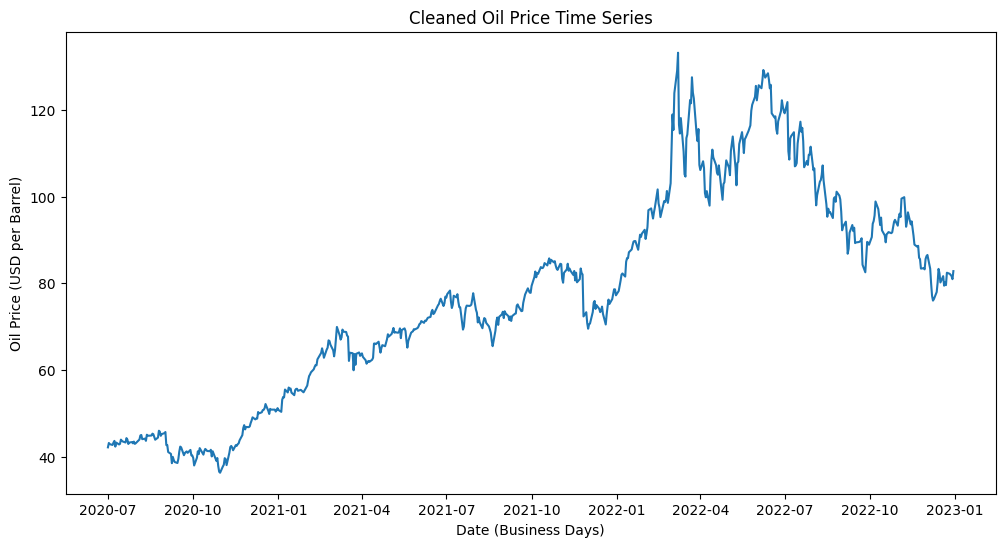

In [63]:
# Plot the cleaned oil price time series
plt.figure(figsize=(12, 6))

# Line plot: x-axis is the business-day index, y-axis is oil price
plt.plot(Oil_price_Clean.index, Oil_price_Clean['Price'])

# Add title and axis labels for clarity
plt.title('Cleaned Oil Price Time Series')
plt.xlabel('Date (Business Days)')
plt.ylabel('Oil Price (USD per Barrel)')

# Display the plot
plt.show()


In [64]:
# Run (ADF) of the cleaned oil price series
adf_result = adfuller(Oil_price_Clean['Price'])

# Display the test statistic which indicates how strongly we can reject non-stationarity
print(f"ADF Test Statistic: {adf_result[0]:.4f}")

# Show the p-value: if below typical thresholds (0.05 or 0.01), the series is likely stationary
print(f"P-value: {adf_result[1]:.4f}")

# Print the critical values at 1%, 5%, and 10% significance levels for decision reference
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value:.4f}")

ADF Test Statistic: -1.6665
P-value: 0.4485
Critical Values:
   1%: -3.4407
   5%: -2.8661
   10%: -2.5692


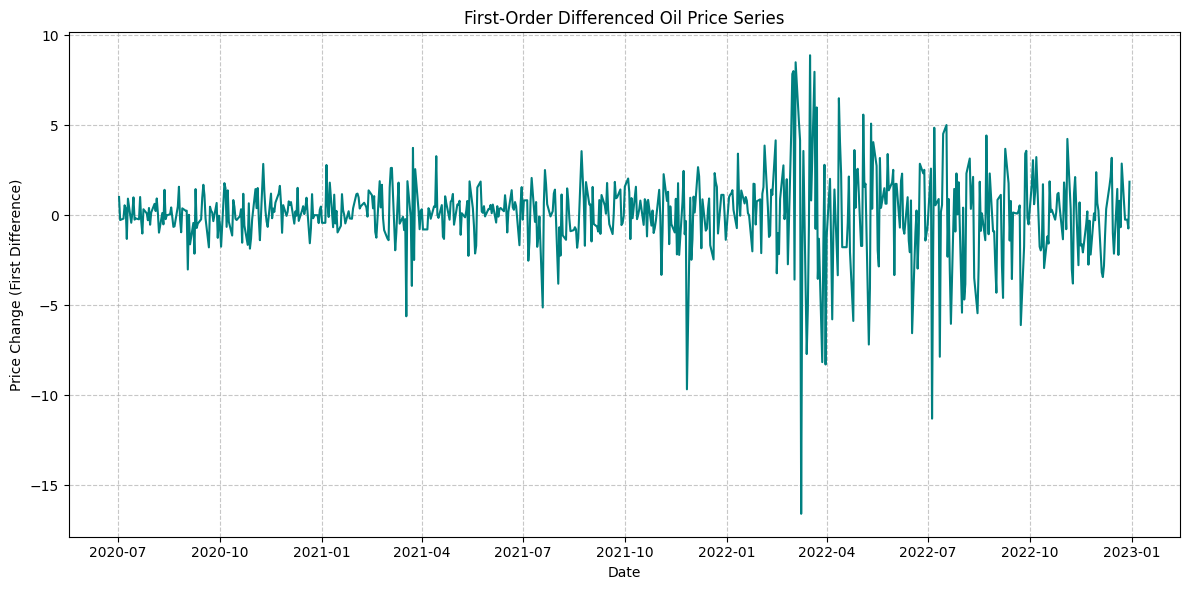

In [65]:
# Perform first-order differencing to transform the non-stationary series
# This removes trend and helps stabilize variance over time
price_diff = Oil_price_Clean['Price'].diff().dropna()

# Set up a plot to visualize the differenced series
plt.figure(figsize=(12, 6))

# Plot the differenced oil price values
plt.plot(price_diff, color='teal', linewidth=1.5)

# Add title and axis labels for context
plt.title('First-Order Differenced Oil Price Series')
plt.xlabel('Date')
plt.ylabel('Price Change (First Difference)')

# Add a subtle grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Use tight layout to avoid overlap of labels
plt.tight_layout()

# Show the final plot
plt.show()

In [ ]:
# Re-run the Augmented Dickey-Fuller test on the first-order differenced series
# This checks if the differencing step successfully made the series stationary

diff_adf_output = adfuller(price_diff)

# Display the ADF test statistic for the differenced data
# A more negative statistic usually indicates stronger stationarity
print('ADF Statistic for Stationarity (Differenced):', diff_adf_output[0])

# Show the p-value: a low p-value confirms we can reject the null hypothesis of non-stationarity
print('ADF p-Value (1st Difference):', diff_adf_output[1])

# Output the critical values at standard significance levels for comparison
print('Augmented Dickey-Fuller Critical Values:', diff_adf_output[4])

ADF Statistic for Stationarity (Differenced): -4.72805027358363
ADF p-Value (1st Difference): 7.451410062621789e-05
Augmented Dickey-Fuller Critical Values: {'1%': np.float64(-3.4406900498266193), '5%': np.float64(-2.8661023102613137), '10%': np.float64(-2.569199643499287)}


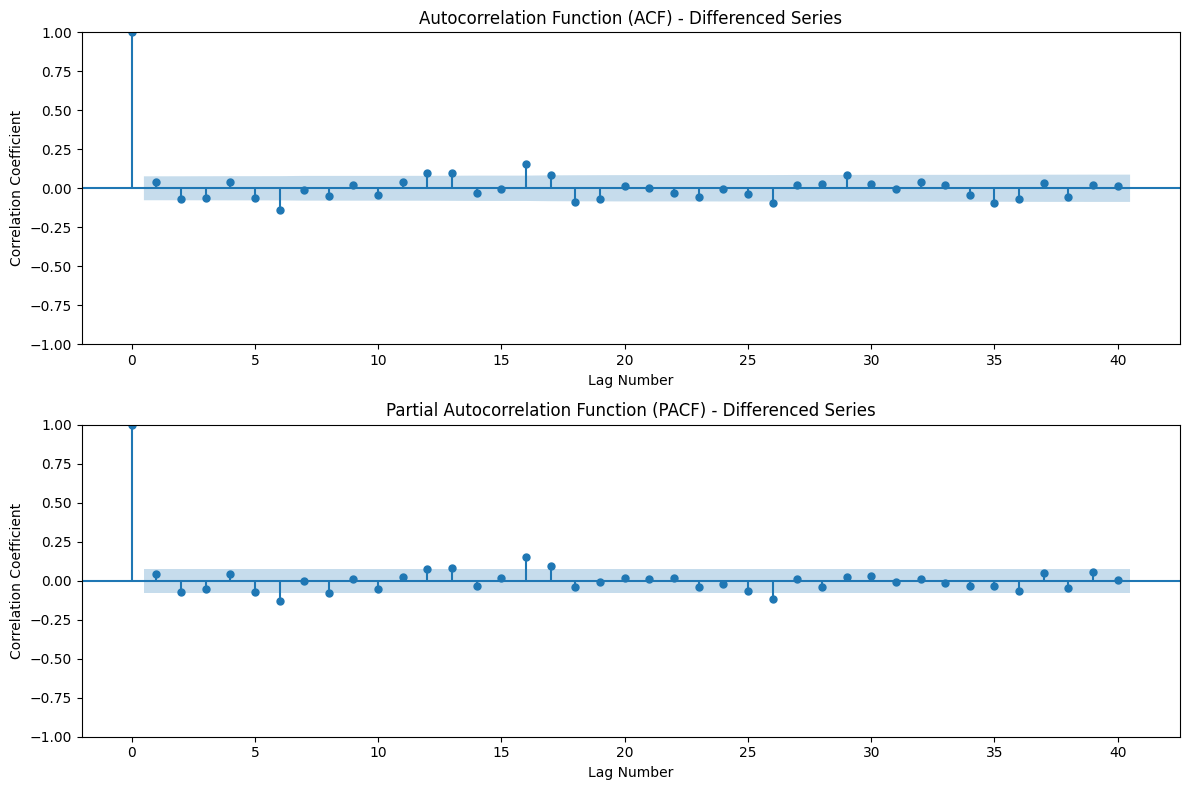

In [66]:
# Visualize the autocorrelation and partial autocorrelation structure
# for the first-order differenced oil price series
# This helps identify suitable AR (AutoRegressive) and MA (Moving Average) orders

# Create two vertically stacked subplots: one for ACF, one for PACF
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot the ACF to see how the current value relates to its past lags
plot_acf(price_diff, ax=axes[0], lags=40)
axes[0].set_title('Autocorrelation Function (ACF) - Differenced Series')

# Plot the PACF to identify the direct correlation at each lag,
# controlling for the effects of intervening lags
plot_pacf(price_diff, ax=axes[1], lags=40, method='ywm')
axes[1].set_title('Partial Autocorrelation Function (PACF) - Differenced Series')

# Add axis labels for clarity
for ax in axes:
    ax.set_xlabel('Lag Number')
    ax.set_ylabel('Correlation Coefficient')

# Adjust spacing to prevent label overlap
plt.tight_layout()

# Display the final plots
plt.show()


### ARIMA GRID SEARCH


In [67]:
# Initialize variables to keep track of the lowest AIC score found,
# the best (p,d,q) parameter combination, and the corresponding model fit
min_aic_score = np.inf  # Start with infinity so any real AIC will be lower
selected_order = None   # To store the best (p,d,q) combination
best_fitted_arima = None  # To hold the best fitted ARIMA model

# Perform a grid search over specified ranges for p, d, and q
# p: AR order, d: degree of differencing, q: MA order
for p in range(0, 9):
    for d in range(0, 3):
        for q in range(0, 9):
            try:
                # Initialize and fit an ARIMA model with current parameters
                model = ARIMA(Oil_price_Clean['Price'], order=(p,d,q))
                model_fit = model.fit()

                # If this model's AIC is lower than previous best, update tracking variables
                if model_fit.aic < min_aic_score:
                    min_aic_score = model_fit.aic
                    selected_order = (p,d,q)
                    best_fitted_arima = model_fit

                # Print out the current model's AIC for monitoring progress
                print(f'ARIMA({p},{d},{q}) AIC: {model_fit.aic:.2f}')

            except:
                # Continue silently if the model fails to converge for some parameters
                continue

# Display the optimal model configuration found from the grid search
print(f"\nOptimal ARIMA Order: {selected_order} with Lowest AIC: {min_aic_score:.2f}")

ARIMA(0,0,0) AIC: 5998.29
ARIMA(0,0,1) AIC: 5160.72
ARIMA(0,0,2) AIC: 4554.80
ARIMA(0,0,3) AIC: 4130.89
ARIMA(0,0,4) AIC: 3894.39
ARIMA(0,0,5) AIC: 3684.73
ARIMA(0,0,6) AIC: 3555.00
ARIMA(0,0,7) AIC: 3445.49
ARIMA(0,0,8) AIC: 4254.56
ARIMA(0,1,0) AIC: 2887.86
ARIMA(0,1,1) AIC: 2888.47
ARIMA(0,1,2) AIC: 2887.89
ARIMA(0,1,3) AIC: 2885.41
ARIMA(0,1,4) AIC: 2886.94
ARIMA(0,1,5) AIC: 2886.38
ARIMA(0,1,6) AIC: 2878.58
ARIMA(0,1,7) AIC: 2880.35
ARIMA(0,1,8) AIC: 2881.41
ARIMA(0,2,0) AIC: 3306.63
ARIMA(0,2,1) AIC: 2892.40
ARIMA(0,2,2) AIC: 2892.96
ARIMA(0,2,3) AIC: 2892.45
ARIMA(0,2,4) AIC: 2890.05
ARIMA(0,2,5) AIC: 2891.56
ARIMA(0,2,6) AIC: 2891.00
ARIMA(0,2,7) AIC: 2882.96
ARIMA(0,2,8) AIC: 2884.77
ARIMA(1,0,0) AIC: 2899.59
ARIMA(1,0,1) AIC: 2900.07
ARIMA(1,0,2) AIC: 2899.68
ARIMA(1,0,3) AIC: 2897.45
ARIMA(1,0,4) AIC: 2899.03
ARIMA(1,0,5) AIC: 2898.65
ARIMA(1,0,6) AIC: 2891.02
ARIMA(1,0,7) AIC: 2892.76
ARIMA(1,0,8) AIC: 2893.85
ARIMA(1,1,0) AIC: 2888.66
ARIMA(1,1,1) AIC: 2889.83
ARIMA(1,1,2)

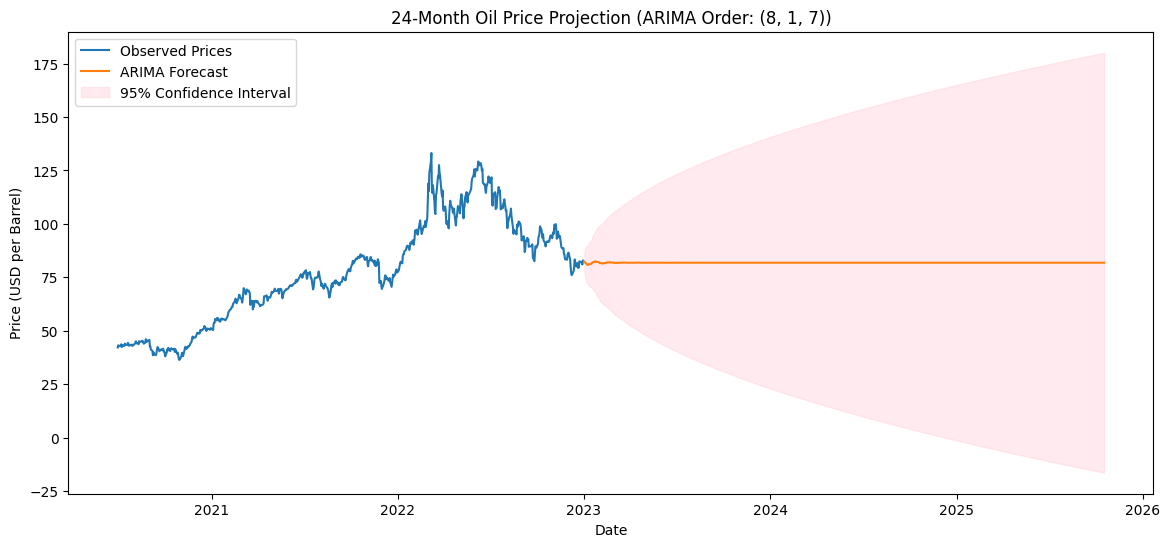

In [68]:
# Use the optimal ARIMA model to forecast the next 730 business days (~2 years)
forecast = best_fitted_arima.get_forecast(steps=730)

# Extract the point forecasts (mean predictions)
forecast_point_estimates = forecast.predicted_mean

# Get the confidence intervals for the forecast to visualize uncertainty
intervals_df = forecast.conf_int()

plt.figure(figsize=(14, 6))

# Plot the original cleaned oil price series
plt.plot(Oil_price_Clean.index, Oil_price_Clean['Price'], label='Observed Prices')

# Plot the forecasted point estimates
plt.plot(forecast_point_estimates.index, forecast_point_estimates, label='ARIMA Forecast')

# Shade the area between the lower and upper confidence bounds
plt.fill_between(
    forecast_point_estimates.index,
    intervals_df.iloc[:, 0],
    intervals_df.iloc[:, 1],
    color='pink',
    alpha=0.3,
    label='95% Confidence Interval'
)

# Add plot titles and labels
plt.title(f"24-Month Oil Price Projection (ARIMA Order: {selected_order})")
plt.xlabel('Date')
plt.ylabel('Price (USD per Barrel)')
plt.legend()
plt.show()


In [96]:
# Reserve 80% of data for training, 20% for testing
train_set_length = int(len(Oil_price_Clean) * 0.8)
train = Oil_price_Clean['Price'][:train_set_length]
test = Oil_price_Clean['Price'][train_set_length:]

# Fit ARIMA with the selected (p,d,q) order on the training portion
model = ARIMA(train, order=selected_order)
model_fit = model.fit()

# Generate out-of-sample forecasts equal to the length of the test set
preds = model_fit.forecast(steps=len(test))

# Calculate Root Mean Squared Error (RMSE) between actual test values and predictions
rmse = np.sqrt(mean_squared_error(test, preds))

# Print the test RMSE result for performance tracking
print(f'Test RMSE for ARIMA{selected_order}: {rmse:.2f}')


Test RMSE for ARIMA(1, 1, 1): 27.18



### COMPARE WITH ACTUAL BRENT PRICES


In [70]:
# Read the Brent oil price CSV file, ensuring Date column is parsed as datetime objects
brent_df = pd.read_csv('RBRTEdcsv.csv')

# Rename columns for clarity
brent_df.columns = ['Date', 'Price']

# Convert the 'Date' column to datetime, handling any mixed formats
brent_df['Date'] = pd.to_datetime(brent_df['Date'], format='mixed')

# Set the Date column as the index for time series operations and sort by date
brent_df = brent_df.set_index('Date').sort_index()

# Display the first few rows to confirm data loaded correctly
print(brent_df.head())


            Price
Date             
1987-05-20  18.63
1987-05-21  18.45
1987-05-22  18.55
1987-05-25  18.60
1987-05-26  18.63


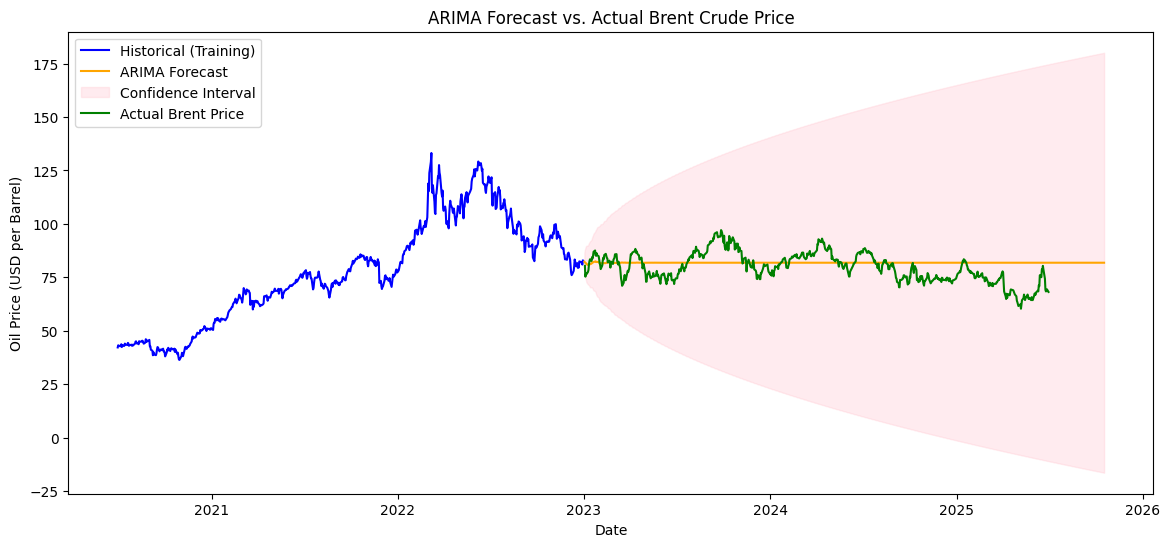

In [71]:
# Filter Brent crude oil data to include only dates after the end of the training dataset
brent_actual = brent_df[brent_df.index > Oil_price_Clean.index[-1]]

# Create a plot to compare the training series, ARIMA forecast, and actual Brent prices
plt.figure(figsize=(14, 6))

# Plot historical cleaned oil price data used for training
plt.plot(Oil_price_Clean.index, Oil_price_Clean['Price'], label='Historical (Training)', color='blue')

# Plot the ARIMA model's forecasted mean prices for the next 24 months
plt.plot(forecast_point_estimates.index, forecast_point_estimates, label='ARIMA Forecast', color='orange')

# Add shaded confidence interval bands around the ARIMA forecast
plt.fill_between(
    forecast_point_estimates.index,
    intervals_df.iloc[:, 0],
    intervals_df.iloc[:, 1],
    color='pink',
    alpha=0.3,
    label='Confidence Interval'
)

# Plot actual Brent crude prices for the same forecast period
plt.plot(brent_actual.index, brent_actual['Price'], label='Actual Brent Price', color='green')

# Add title and axis labels for clarity
plt.title('ARIMA Forecast vs. Actual Brent Crude Price')
plt.xlabel('Date')
plt.ylabel('Oil Price (USD per Barrel)')

# Show legend to distinguish series
plt.legend()

# Display the comparison plot
plt.show()


In [72]:
# Align the forecasted dates with the actual Brent price dates
# Only keep dates that exist in both series to ensure a fair comparison
aligned_actual = brent_actual['Price'].loc[
    forecast_point_estimates.index.intersection(brent_actual.index)
]

aligned_forecast = forecast_point_estimates.loc[aligned_actual.index]

# Compute Root Mean Squared Error between forecast and actual prices
rmse_vs_actual = np.sqrt(mean_squared_error(aligned_actual, aligned_forecast))

# Display the RMSE to evaluate forecast accuracy against real Brent prices
print(f"ARIMA RMSE vs Actual Brent: {rmse_vs_actual:.2f}")


ARIMA RMSE vs Actual Brent: 7.25



# PART 2

## 1. PROPHET + HYPERTUNING

In [73]:
# Prophet requires columns named 'ds' for date and 'y' for the target value
# Reset the index to convert the datetime index into a column
prophet_ready_data = Oil_price_Clean.reset_index().rename(columns={
    'index': 'ds',
    'Price': 'y'
})


# Use 80% of the data for training, 20% for validation
train_set_length = int(len(prophet_ready_data) * 0.8)
train_df = prophet_ready_data.iloc[:train_set_length]
test_df = prophet_ready_data.iloc[train_set_length:]

print(f"Training data points: {len(train_df)}")
print(f"Testing data points: {len(test_df)}")



# A smaller CPS makes the trend smoother, larger CPS allows more rapid changes
cps_values = [0.001, 0.01, 0.1, 0.5]

# Initialize variables to keep track of the best CPS and its RMSE
optimal_rmse = float('inf')
optimal_cps_value = None


Training data points: 522
Testing data points: 131


In [74]:
# Loop through each candidate CPS value to test model flexibility
for cps in cps_values:
    # Initialize a new Prophet model with current CPS and daily seasonality enabled
    model = Prophet(changepoint_prior_scale=cps, daily_seasonality=True)

    # Fit the model using only the training data
    model.fit(train_df)

    # Generate future dataframe equal in length to the test set
    future = model.make_future_dataframe(periods=len(test_df))

    # Produce forecast for the combined training + test period
    forecast = model.predict(future)

    # Extract actual and predicted values for the test set period only
    y_true = test_df['y'].values
    y_pred = forecast['yhat'].iloc[-len(test_df):].values

    # Compute RMSE for this CPS value
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"CPS: {cps} | Validation RMSE: {rmse:.2f}")

    # Update best CPS if this one achieves a lower RMSE
    if rmse < optimal_rmse:
        optimal_rmse = rmse
        optimal_cps_value = cps

print(f"\nOptimal changepoint_prior_scale: {optimal_cps_value} | Best Validation RMSE: {optimal_rmse:.2f}")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxvvab0_r/77eb6ira.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxvvab0_r/fqu8sy64.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15911', 'data', 'file=/tmp/tmpxvvab0_r/77eb6ira.json', 'init=/tmp/tmpxvvab0_r/fqu8sy64.json', 'output', 'file=/tmp/tmpxvvab0_r/prophet_model9oi71k93/prophet_model-20250707095845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:58:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:58:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/t

CPS: 0.001 | Validation RMSE: 27.84


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxvvab0_r/201km96m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxvvab0_r/s2itmk8s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60674', 'data', 'file=/tmp/tmpxvvab0_r/201km96m.json', 'init=/tmp/tmpxvvab0_r/s2itmk8s.json', 'output', 'file=/tmp/tmpxvvab0_r/prophet_model2trut732/prophet_model-20250707095845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:58:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:58:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPS: 0.01 | Validation RMSE: 41.51


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxvvab0_r/get0o8ql.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxvvab0_r/chalrqbp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74001', 'data', 'file=/tmp/tmpxvvab0_r/get0o8ql.json', 'init=/tmp/tmpxvvab0_r/chalrqbp.json', 'output', 'file=/tmp/tmpxvvab0_r/prophet_model3cqm7lff/prophet_model-20250707095846.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:58:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


CPS: 0.1 | Validation RMSE: 45.11


09:58:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPS: 0.5 | Validation RMSE: 41.62

Optimal changepoint_prior_scale: 0.001 | Best Validation RMSE: 27.84


In [75]:
# Initialize a new Prophet model with the best CPS found from tuning
final_prophet = Prophet(
    changepoint_prior_scale=optimal_cps_value,  # Best flexibility for trend changepoints
    daily_seasonality=True                      # Enable daily seasonality
)

# Fit the Prophet model on the entire cleaned dataset
final_prophet.fit(prophet_ready_data)

# Create a future dataframe to forecast 24 months ahead (approx. 730 days)
future = final_prophet.make_future_dataframe(periods=730)

# Generate final forecast for the extended period
forecast = final_prophet.predict(future)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpxvvab0_r/h0v__db5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxvvab0_r/ioi0cz4j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30667', 'data', 'file=/tmp/tmpxvvab0_r/h0v__db5.json', 'init=/tmp/tmpxvvab0_r/ioi0cz4j.json', 'output', 'file=/tmp/tmpxvvab0_r/prophet_modelt9mlwf8q/prophet_model-20250707095915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:59:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:59:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
09:59:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxvvab0_r/ix0tqjhj.json
DE

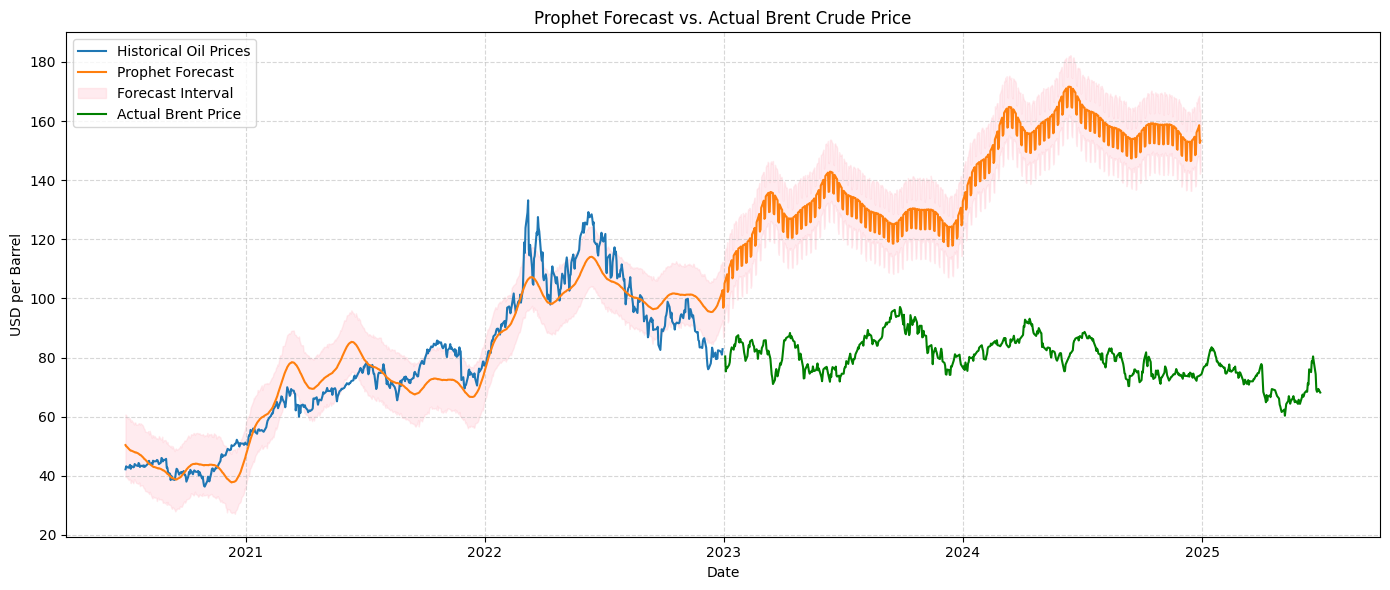

In [77]:
plt.figure(figsize=(14, 6))

# Plot the original historical oil prices used for Prophet
plt.plot(
    prophet_ready_data['ds'],
    prophet_ready_data['y'],
    label='Historical Oil Prices'
)

# Plot the Prophet model’s predicted mean values
plt.plot(
    forecast['ds'],
    forecast['yhat'],
    label='Prophet Forecast'
)

# Add the confidence interval (uncertainty bands)
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    color='pink',
    alpha=0.3,
    label='Forecast Interval'
)

# Overlay the actual Brent prices for the same period after the forecast
plt.plot(
    brent_actual.index,
    brent_actual['Price'],
    label='Actual Brent Price',
    color='green'
)

# Final plot styling
plt.title('Prophet Forecast vs. Actual Brent Crude Price')
plt.xlabel('Date')
plt.ylabel('USD per Barrel')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [78]:
# Merge the Prophet forecast and actual Brent prices on matching dates
merged_df = pd.merge(
    forecast.set_index('ds'),
    brent_actual['Price'],
    left_index=True,
    right_index=True,
    how='inner'  # Only keep dates that exist in both datasets
)

# Extract the aligned predicted and actual price series
aligned_forecast = merged_df['yhat']
aligned_actual = merged_df['Price']

# Compute Root Mean Squared Error (RMSE)
rmse_prophet_vs_actual = np.sqrt(
    mean_squared_error(aligned_actual, aligned_forecast)
)

print(f'Prophet RMSE vs Actual Brent: {rmse_prophet_vs_actual:.2f}')

Prophet RMSE vs Actual Brent: 64.50


## 3. SARIMA, Seasonal Order Grid

### DIVIDE TIME SERIES INTO TRAIN AND TEST PORTIONS


In [79]:
# Divide the cleaned oil price series into training and testing sets
# Use an 80/20 split to train the time series model on the bulk of the data

# Calculate the split index for 80% training data
train_set_length = int(len(Oil_price_Clean) * 0.8)

# Create training dataset slice
train = Oil_price_Clean['Price'][:train_set_length]

# Create testing dataset slice
test = Oil_price_Clean['Price'][train_set_length:]

# Print out the sizes of each subset for verification
print(f'Training samples count: {len(train)}')
print(f'Testing samples count: {len(test)}')


Training samples count: 522
Testing samples count: 131



### SEASONAL GRID SEARCH TO FIND BEST ORDERS


In [89]:
import itertools

# Define ranges for non-seasonal parameters: p, d, q
p = d = q = range(0, 2)

# Define ranges for seasonal parameters: P, D, Q and seasonal period s
P = D = Q = range(0, 2)
s = [5, 7]  # Try two possible seasonal cycles: 5 and 7 (weekly for business days)

# Create all possible combinations of non-seasonal and seasonal parameters
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))

# Initialize tracking variables to store the best AIC score and corresponding parameters
min_aic_score = np.inf
selected_order = None
best_seasonal_order = None

# Loop through all combinations of parameter sets
for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            # Create SARIMAX model with given non-seasonal and seasonal order
            model = SARIMAX(train, order=order, seasonal_order=seasonal_order)

            # Fit the model to training data
            results = model.fit(disp=False)

            # If current model's AIC is lower, save its configuration
            if results.aic < min_aic_score:
                min_aic_score = results.aic
                selected_order = order
                best_seasonal_order = seasonal_order

            # Print progress for each combination tried
            print(f'SARIMA{order}x{seasonal_order} AIC:{results.aic}')

        except:
            # If the model fails to fit, skip to next combination
            continue

# Print the final best SARIMA configuration and its AIC
print(f'\n Best SARIMA order: {selected_order} Seasonal: {best_seasonal_order} AIC:{min_aic_score}')


SARIMA(0, 0, 0)x(0, 0, 0, 5) AIC:6016.8239567946575
SARIMA(0, 0, 0)x(0, 0, 0, 7) AIC:6016.8239567946575
SARIMA(0, 0, 0)x(0, 0, 1, 5) AIC:5358.372088403062
SARIMA(0, 0, 0)x(0, 0, 1, 7) AIC:5379.614378268641
SARIMA(0, 0, 0)x(0, 1, 0, 5) AIC:3074.3785853312193
SARIMA(0, 0, 0)x(0, 1, 0, 7) AIC:3203.8859419315777
SARIMA(0, 0, 0)x(0, 1, 1, 5) AIC:3054.0177700254003
SARIMA(0, 0, 0)x(0, 1, 1, 7) AIC:3187.6988068859546
SARIMA(0, 0, 0)x(1, 0, 0, 5) AIC:3135.119600747903
SARIMA(0, 0, 0)x(1, 0, 0, 7) AIC:3288.015622602972
SARIMA(0, 0, 0)x(1, 0, 1, 5) AIC:3114.9191067931947
SARIMA(0, 0, 0)x(1, 0, 1, 7) AIC:3272.1063917739607
SARIMA(0, 0, 0)x(1, 1, 0, 5) AIC:3052.3606526300346
SARIMA(0, 0, 0)x(1, 1, 0, 7) AIC:3179.337443493279
SARIMA(0, 0, 0)x(1, 1, 1, 5) AIC:3054.25088792582
SARIMA(0, 0, 0)x(1, 1, 1, 7) AIC:3161.0851027912804
SARIMA(0, 0, 1)x(0, 0, 0, 5) AIC:5310.79049270216
SARIMA(0, 0, 1)x(0, 0, 0, 7) AIC:5310.79049270216
SARIMA(0, 0, 1)x(0, 0, 1, 5) AIC:4751.066512420319
SARIMA(0, 0, 1)x(0, 0, 1

### FIT FINAL SARIMA ON TRAIN, FORECAST TEST PERIOD

In [91]:

# Fit the final SARIMA model using the selected non-seasonal and seasonal orders


sarima_model = SARIMAX(
    train,  # Training data series
    order=selected_order,  # Optimal non-seasonal order (p,d,q)
    seasonal_order=best_seasonal_order  # Optimal seasonal order (P,D,Q,s)
)

# Fit the SARIMA model to the training data
sarima_result = sarima_model.fit(disp=False)


# Generate forecast for the test period


sarima_preds_test = sarima_result.forecast(steps=len(test))

# Evaluate performance using Root Mean Squared Error (RMSE)

rmse_test_sarima = np.sqrt(mean_squared_error(test, sarima_preds_test))

print(f'\nSARIMA Test RMSE: {rmse_test_sarima:.2f}')



SARIMA Test RMSE: 26.96


### FIT FINAL SARIMA ON FULL DATA, FORECAST 24 MONTHS AHEAD


In [92]:

# Fit SARIMA model on the full cleaned data
# using the selected non-seasonal and seasonal orders


final_sarima_full = SARIMAX(
    Oil_price_Clean['Price'],     # Full dataset: cleaned daily oil prices
    order=selected_order,         # Optimal non-seasonal (p,d,q)
    seasonal_order=best_seasonal_order  # Optimal seasonal (P,D,Q,s)
)

# Fit the SARIMA model to the entire data
sarima_result_full = final_sarima_full.fit(disp=False)


# Generate forecast for the next 24 months (730 days)


forecast_full = sarima_result_full.get_forecast(steps=730)

# Extract point estimates for the forecasted prices
forecast_point_estimates = forecast_full.predicted_mean

# Extract the confidence intervals for the forecast
intervals_df = forecast_full.conf_int()


### COMPARE TO ACTUAL BRENT PRICES

In [93]:

# Align forecasted SARIMA dates with actual Brent crude prices


# Find the overlapping dates between SARIMA forecast and Brent actual data
aligned_actual = brent_actual['Price'].loc[
    forecast_point_estimates.index.intersection(brent_actual.index)
]

# Extract the corresponding forecasted values for those dates
aligned_forecast = forecast_point_estimates.loc[aligned_actual.index]


# Calculate RMSE to evaluate how well the SARIMA forecast matches actual Brent prices


rmse_vs_actual_sarima = np.sqrt(mean_squared_error(aligned_actual, aligned_forecast))

print(f'SARIMA RMSE vs Actual Brent: {rmse_vs_actual_sarima:.2f}')


SARIMA RMSE vs Actual Brent: 9.13


### PLOT FINAL SARIMA FORECAST VS ACTUAL

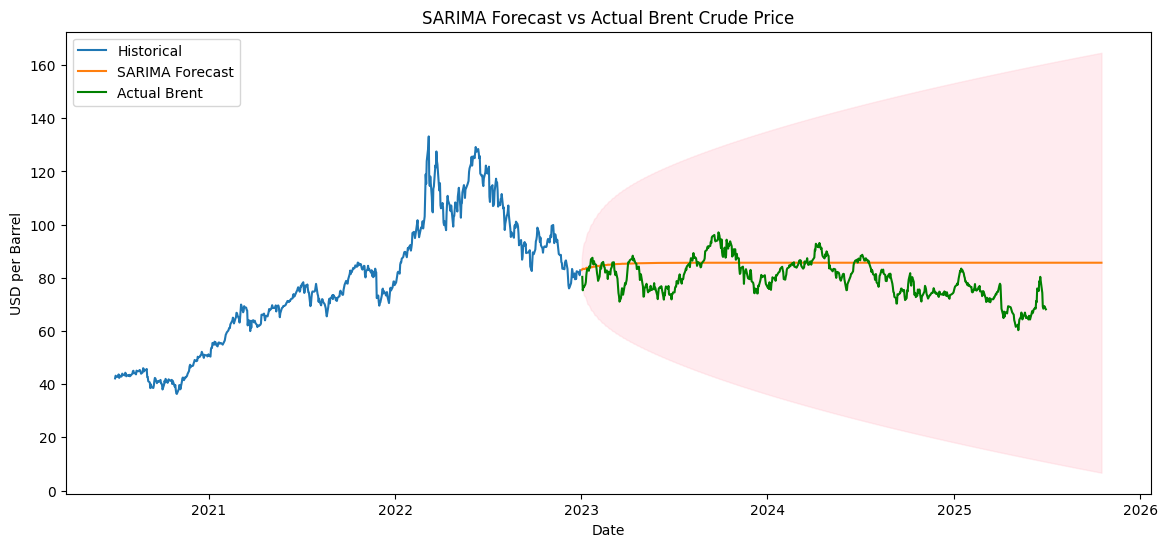

In [94]:

# Visualize SARIMA forecast compared with actual Brent crude prices


plt.figure(figsize=(14, 6))

# Plot the full historical oil prices used for training
plt.plot(Oil_price_Clean.index, Oil_price_Clean['Price'], label='Historical')

# Plot the SARIMA model's 24-month forecast
plt.plot(forecast_point_estimates.index, forecast_point_estimates, label='SARIMA Forecast')

# Add the forecast confidence intervals for uncertainty
plt.fill_between(
    forecast_point_estimates.index,
    intervals_df.iloc[:, 0],
    intervals_df.iloc[:, 1],
    color='pink',
    alpha=0.3
)

# Overlay the actual Brent crude oil prices for the same forecast period
plt.plot(brent_actual.index, brent_actual['Price'], label='Actual Brent', color='green')

# Chart styling: title and axis labels
plt.title('SARIMA Forecast vs Actual Brent Crude Price')
plt.xlabel('Date')
plt.ylabel('USD per Barrel')
plt.legend()
plt.show()


### FINAL OUTPUTS

In [95]:
# Display final SARIMA model summary statistics

# Print the optimal SARIMA model configuration found through grid search
print(f'Best SARIMA Order: {selected_order} Seasonal: {best_seasonal_order}')

# Print the RMSE calculated on the hold-out test set
print(f'Test RMSE: {rmse_test_sarima:.2f}')

# Print the RMSE comparing the final SARIMA forecast to the actual Brent crude prices
print(f'RMSE vs Actual Brent: {rmse_vs_actual_sarima:.2f}')


Best SARIMA Order: (1, 1, 1) Seasonal: (1, 0, 1, 5)
Test RMSE: 26.96
RMSE vs Actual Brent: 9.13
